In [1]:
import numpy as np
import PIL.Image as Image
import os
import matplotlib.pyplot as plt
import matplotlib as mpl
from readPatchOutput import *


repeat = 1
n_pic = 2160
nV1 = 1024
nblock = 5
nE = 768
pixel = '16'
Epick = []
Ipick = []
for i in range(nblock):
    for j in range(nV1):
        if j <nE:
            Epick.append(i*nV1+j)
        else:
            Ipick.append(i*nV1+j)

In [100]:
output_suffix0 = 'static_32pixel_1'
res_suffix = 'minimal-patch'
conLGN_suffix = 'test_lgn' 
conV1_suffix = 'test_v1'
res_suffix = "_" + res_suffix
conLGN_suffix = "_" + conLGN_suffix
conV1_suffix = "_" + conV1_suffix
output_suffix = output_suffix0
_output_suffix = "_" + output_suffix
res_fdr = '/root/autodl-tmp/ljy/resource_static_32pixel/'
setup_fdr = '/root/autodl-tmp/ljy/resource_static_32pixel/'
data_fdr = '/root/autodl-tmp/ljy/data_static_32pixel/'

LGN_V1_sFn = setup_fdr + "LGN_V1_sList" + conLGN_suffix + ".bin"
LGN_V1_idFn = setup_fdr + "LGN_V1_idList" + conLGN_suffix + ".bin"
LGN_spFn = data_fdr + "LGN_sp" + _output_suffix
parameterFn = data_fdr + "patchV1_cfg" +_output_suffix + ".bin"

# prec, sizeofPrec, vL, vE, vI, vR, vThres, gL, vT, typeAcc, nE, nI, sRatioLGN, sRatioV1, frRatioLGN, convolRatio, nType, nTypeE, nTypeI, frameRate, inputFn, _virtual_LGN, tonicDep, noisyDep = read_cfg(parameterFn)
LGN_V1_s = readLGN_V1_s0(LGN_V1_sFn)
LGN_V1_ID, nLGN_V1 = readLGN_V1_ID(LGN_V1_idFn)
# LGN_spScatter = readLGN_sp(LGN_spFn + ".bin", prec = prec)
LGN_V1_idFn = setup_fdr + "LGN_V1_idList" + conLGN_suffix + ".bin"
LGN_V1_ID, nLGN_V1 = readLGN_V1_ID(LGN_V1_idFn) # size为5120
nLGN_V1_E = nLGN_V1[Epick]
output_suffix = 'static_32pixel'

In [101]:
res_fdr = '/root/autodl-tmp/ljy/resource_static_32pixel/'
setup_fdr = '/root/autodl-tmp/ljy/resource_static_32pixel/'
data_fdr = '/root/autodl-tmp/ljy/data_static_32pixel/'
output_suffix = 'static_32pixel'

cfg = []
fr = []
F0_input = []
F1_input = []
for k in range(1,n_pic+1):
    #读取参数文件
    with open(res_fdr+f'static_color-grid_{k}_cfg.bin') as f:
        sf = np.fromfile(f,'f4',1)[0]
        ori = np.fromfile(f,'f4',1)[0]
        phase = np.fromfile(f,'f4',1)[0]
        c = np.fromfile(f,'f4',1)[0]
    cfg.append([sf,ori,phase,c])

    #读取文件
    with open(data_fdr+'sample_OutAndInputCount_'+output_suffix+'_'+str(k)+'.bin') as f:
        sampleSize = np.fromfile(f,'u4',1)[0]
        sample_t0, sample_t1 = np.fromfile(f, 'f4', 2)
        sampleID = np.fromfile(f,'u4',sampleSize)
        sample_spikeCount = np.fromfile(f,'u4',sampleSize)
        F0 = np.fromfile(f,'f4',sampleSize)
        F1 = np.fromfile(f,'f4',sampleSize)    
        if sample_spikeCount.max()>400:
            print(k,sample_spikeCount.max())
    fr.append(sample_spikeCount)
    F0_input.append(F0)
    F1_input.append(F1)
fr = np.array(fr)/(sample_t1-sample_t0)*1000
F0_input = np.array(F0_input)
F1_input = np.array(F1_input)
cfg = np.array(cfg)
nOri = 12

In [102]:
max_idx = np.argmax(fr,axis=0)
max_fr = np.max(fr,axis=0)
max_input = np.zeros(sampleSize)
for i in range(sampleSize):
    max_input[i] = F0_input[:,i][max_idx[i]]
sample_nLGN_V1 = nLGN_V1[sampleID]
max_sf = cfg[:,0][max_idx]
max_ori = cfg[:,1][max_idx]
pref_sf = max_sf
pref_ori = max_ori


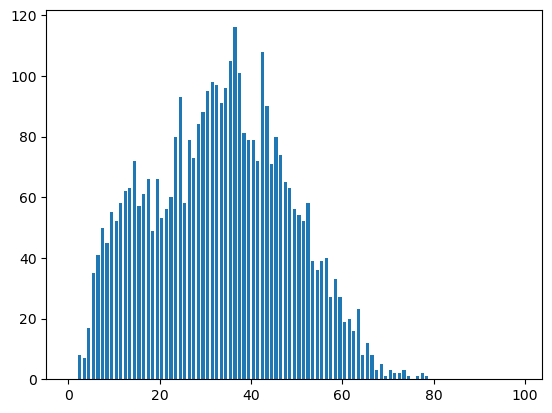

In [103]:
plt.hist(max_fr,bins=np.arange(0,100,1),rwidth=0.7)
plt.show()
plt.close()

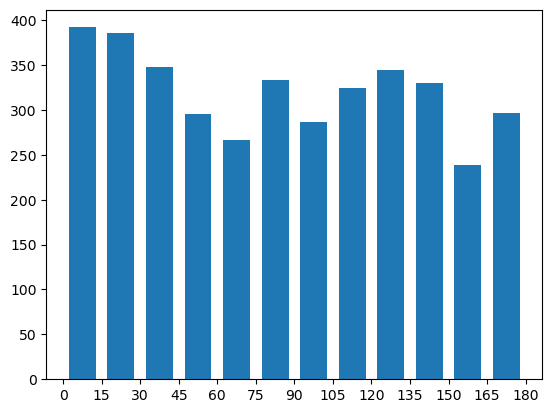

In [104]:
ori_range = np.arange(0,195,15)
plt.hist(max_ori,bins=ori_range,rwidth=0.7)
plt.xticks(ori_range)
plt.show()
plt.close()

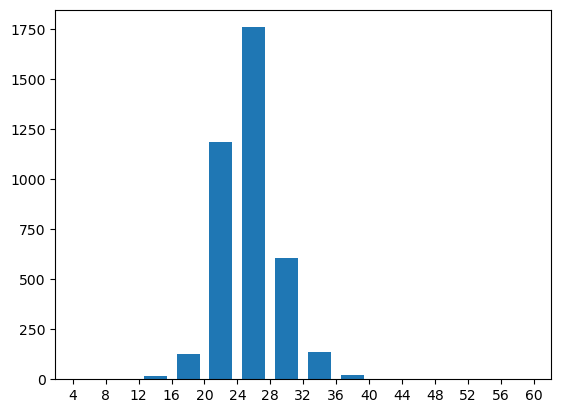

In [105]:
sf_range = np.arange(4,64,4)
plt.hist(max_sf,bins=sf_range,rwidth=0.7)
plt.xticks(sf_range)
plt.show()
plt.close()

In [106]:
FR = fr.reshape((-1,12,sampleSize))
FR = FR.max(axis = 1)
F0_INPUT = F0_input.reshape((-1,12,sampleSize))
F0_INPUT = F0_INPUT.max(axis = 1)
F1_INPUT = F1_input.reshape((-1,12,sampleSize))
F1_INPUT = F1_INPUT.max(axis = 1)
CFG = cfg.reshape((-1,12,4))
CFG = CFG.mean(axis = 1)
fr = FR
F0_input = F0_INPUT
F1_input = F1_INPUT
cfg = CFG

In [116]:
def get_gOSI(tc, nOri):
    ntheta = tc.shape[0]
    nsample = tc.shape[1]
    theta = np.exp(np.tile(1j*np.arange(nOri)/nOri*2*np.pi, (nsample,1)))
    assert(theta.shape[1] == ntheta)
    assert(theta.shape[0] == nsample)
    gOSI = np.zeros(tc.shape[1])
    pick = np.max(tc, axis = 0) > 0
    gOSI[pick] = np.abs(np.sum(tc.T*theta, axis = 1)[pick])/(np.sum(tc.T,axis = 1)[pick])
    assert(gOSI.size == nsample)
    return gOSI
nOri = 12
gOSI = np.zeros(sampleSize)
for k in range(sampleSize):
    tmp_sf = pref_sf[k]
    tmp_fr = fr[:,k][cfg[:,0]==tmp_sf].reshape((-1,1))
    gOSI[k] = get_gOSI(tmp_fr,nOri)[0]



In [122]:
with open('./benchmark_static_32pixel.bin','wb') as f:
    np.array([sampleSize]).astype('u4').tofile(f)
    sampleID.astype('u4').tofile(f)   
    sample_nLGN_V1.astype('u4').tofile(f)
    max_fr.astype('f4').tofile(f)
    max_input.astype('f4').tofile(f)
    max_ori.astype('f4').tofile(f)
    max_sf.astype('f4').tofile(f)    
    gOSI.astype('f4').tofile(f)

In [123]:
with open('./benchmark_static_32pixel.bin') as f:
    sampleSize1 = np.fromfile(f,'u4',1)[0]
    sampleID1 = np.fromfile(f,'u4',sampleSize)
    sample_nLGN_V11 = np.fromfile(f,'u4',sampleSize)        
    max_fr1 = np.fromfile(f,'f4',sampleSize)        
    max_input1 = np.fromfile(f,'f4',sampleSize)        
    max_ori1 = np.fromfile(f,'f4',sampleSize)        
    max_sf1 = np.fromfile(f,'f4',sampleSize)        
    gOSI1 = np.fromfile(f,'f4',sampleSize)        


In [132]:
sum(gOSI1 - gOSI < 0.0001)

3840

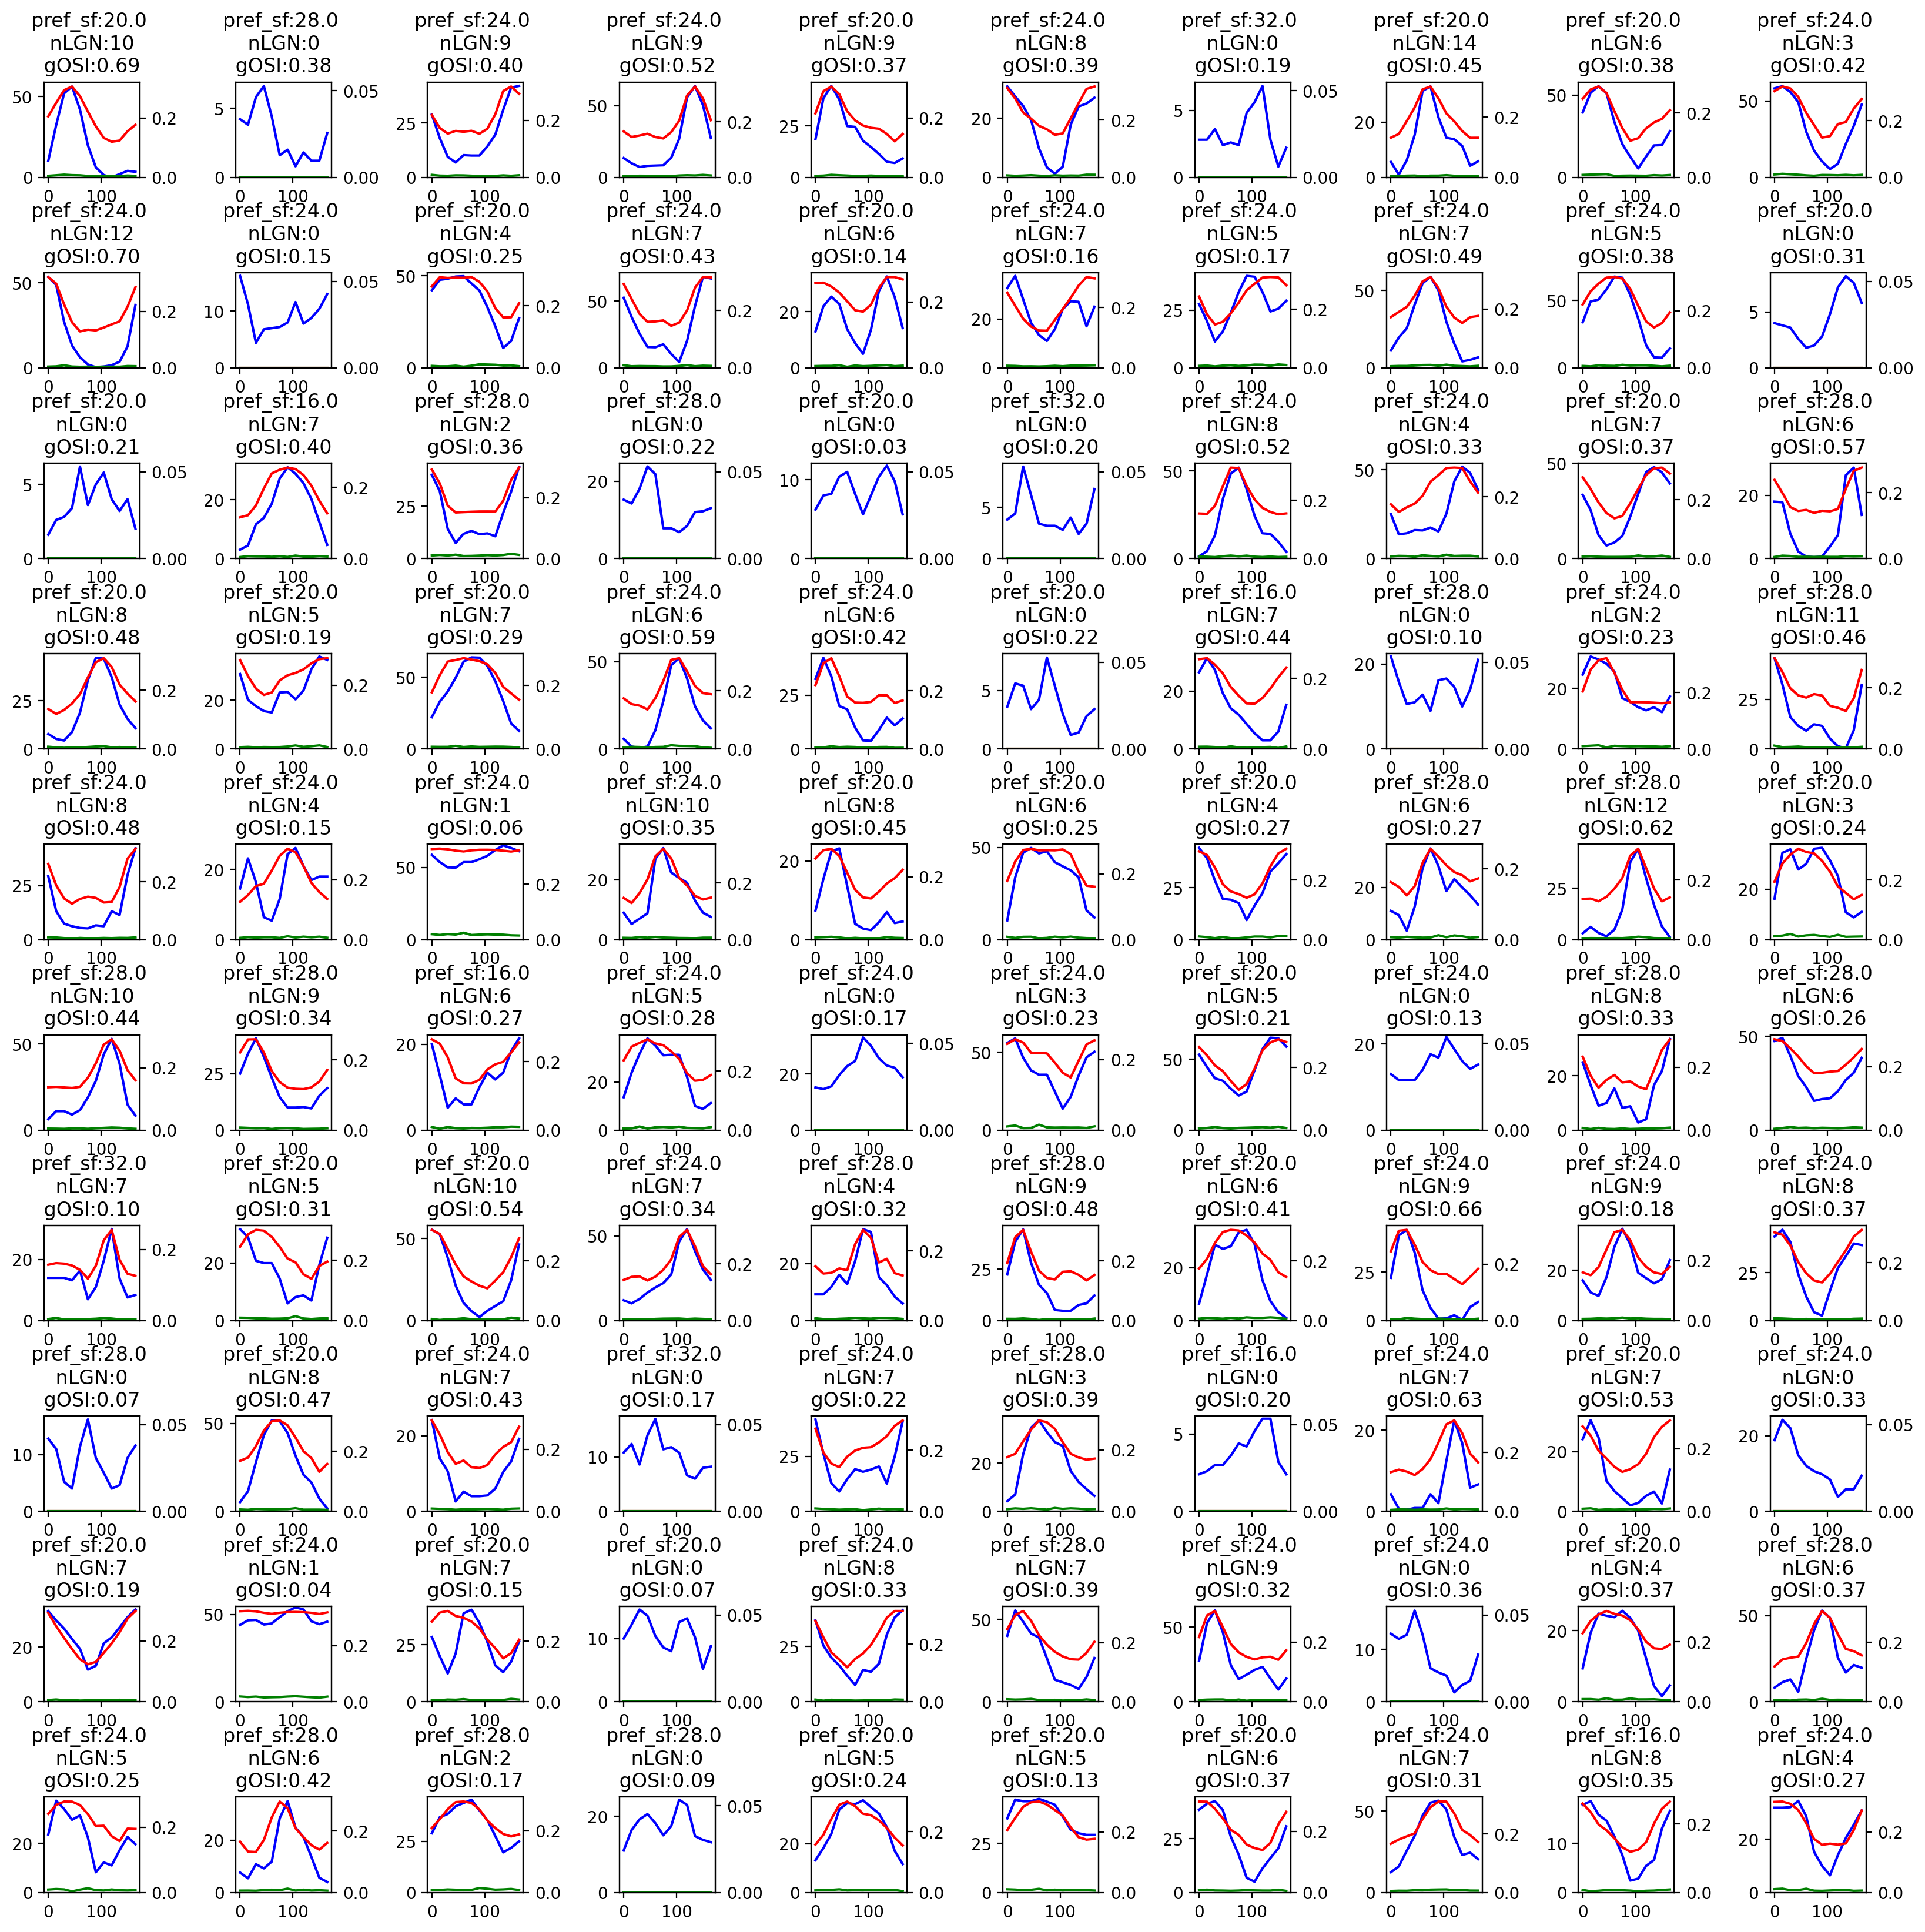

In [118]:
nori = 12
fig = plt.figure(figsize = (20,20),dpi = 200)
fig.subplots_adjust(hspace =1,wspace = 1)
ori = [x*(180/nori) for x in range(nori)]
neu_ind = 5
for k in range(100):
    neu_ind += 5
    tmp_sf = pref_sf[neu_ind]
    tmp_fr = fr[:,neu_ind][cfg[:,0]==tmp_sf]
    tmp_F0 = F0_input[:,neu_ind][cfg[:,0]==tmp_sf]
    tmp_F1 = F1_input[:,neu_ind][cfg[:,0]==tmp_sf]
    
    
    ax = fig.add_subplot(10,10,k+1)
    ax.plot(ori,tmp_fr,'b')
    ax.set_ylim (bottom = 0)
    ax2 = ax.twinx()
    ax2.plot(ori,tmp_F0,'r')
    ax2.plot(ori,tmp_F1,'g')
    ax2.set_ylim (bottom = 0)
    ax.set_title(f'pref_sf:{tmp_sf} \n nLGN:{sample_nLGN_V1[neu_ind]} \n gOSI:{gOSI[neu_ind]:.2f} ')

plt.show()
# fig.savefig('./'+pixel+'_sample_ori_tc.png')        
plt.close()

    


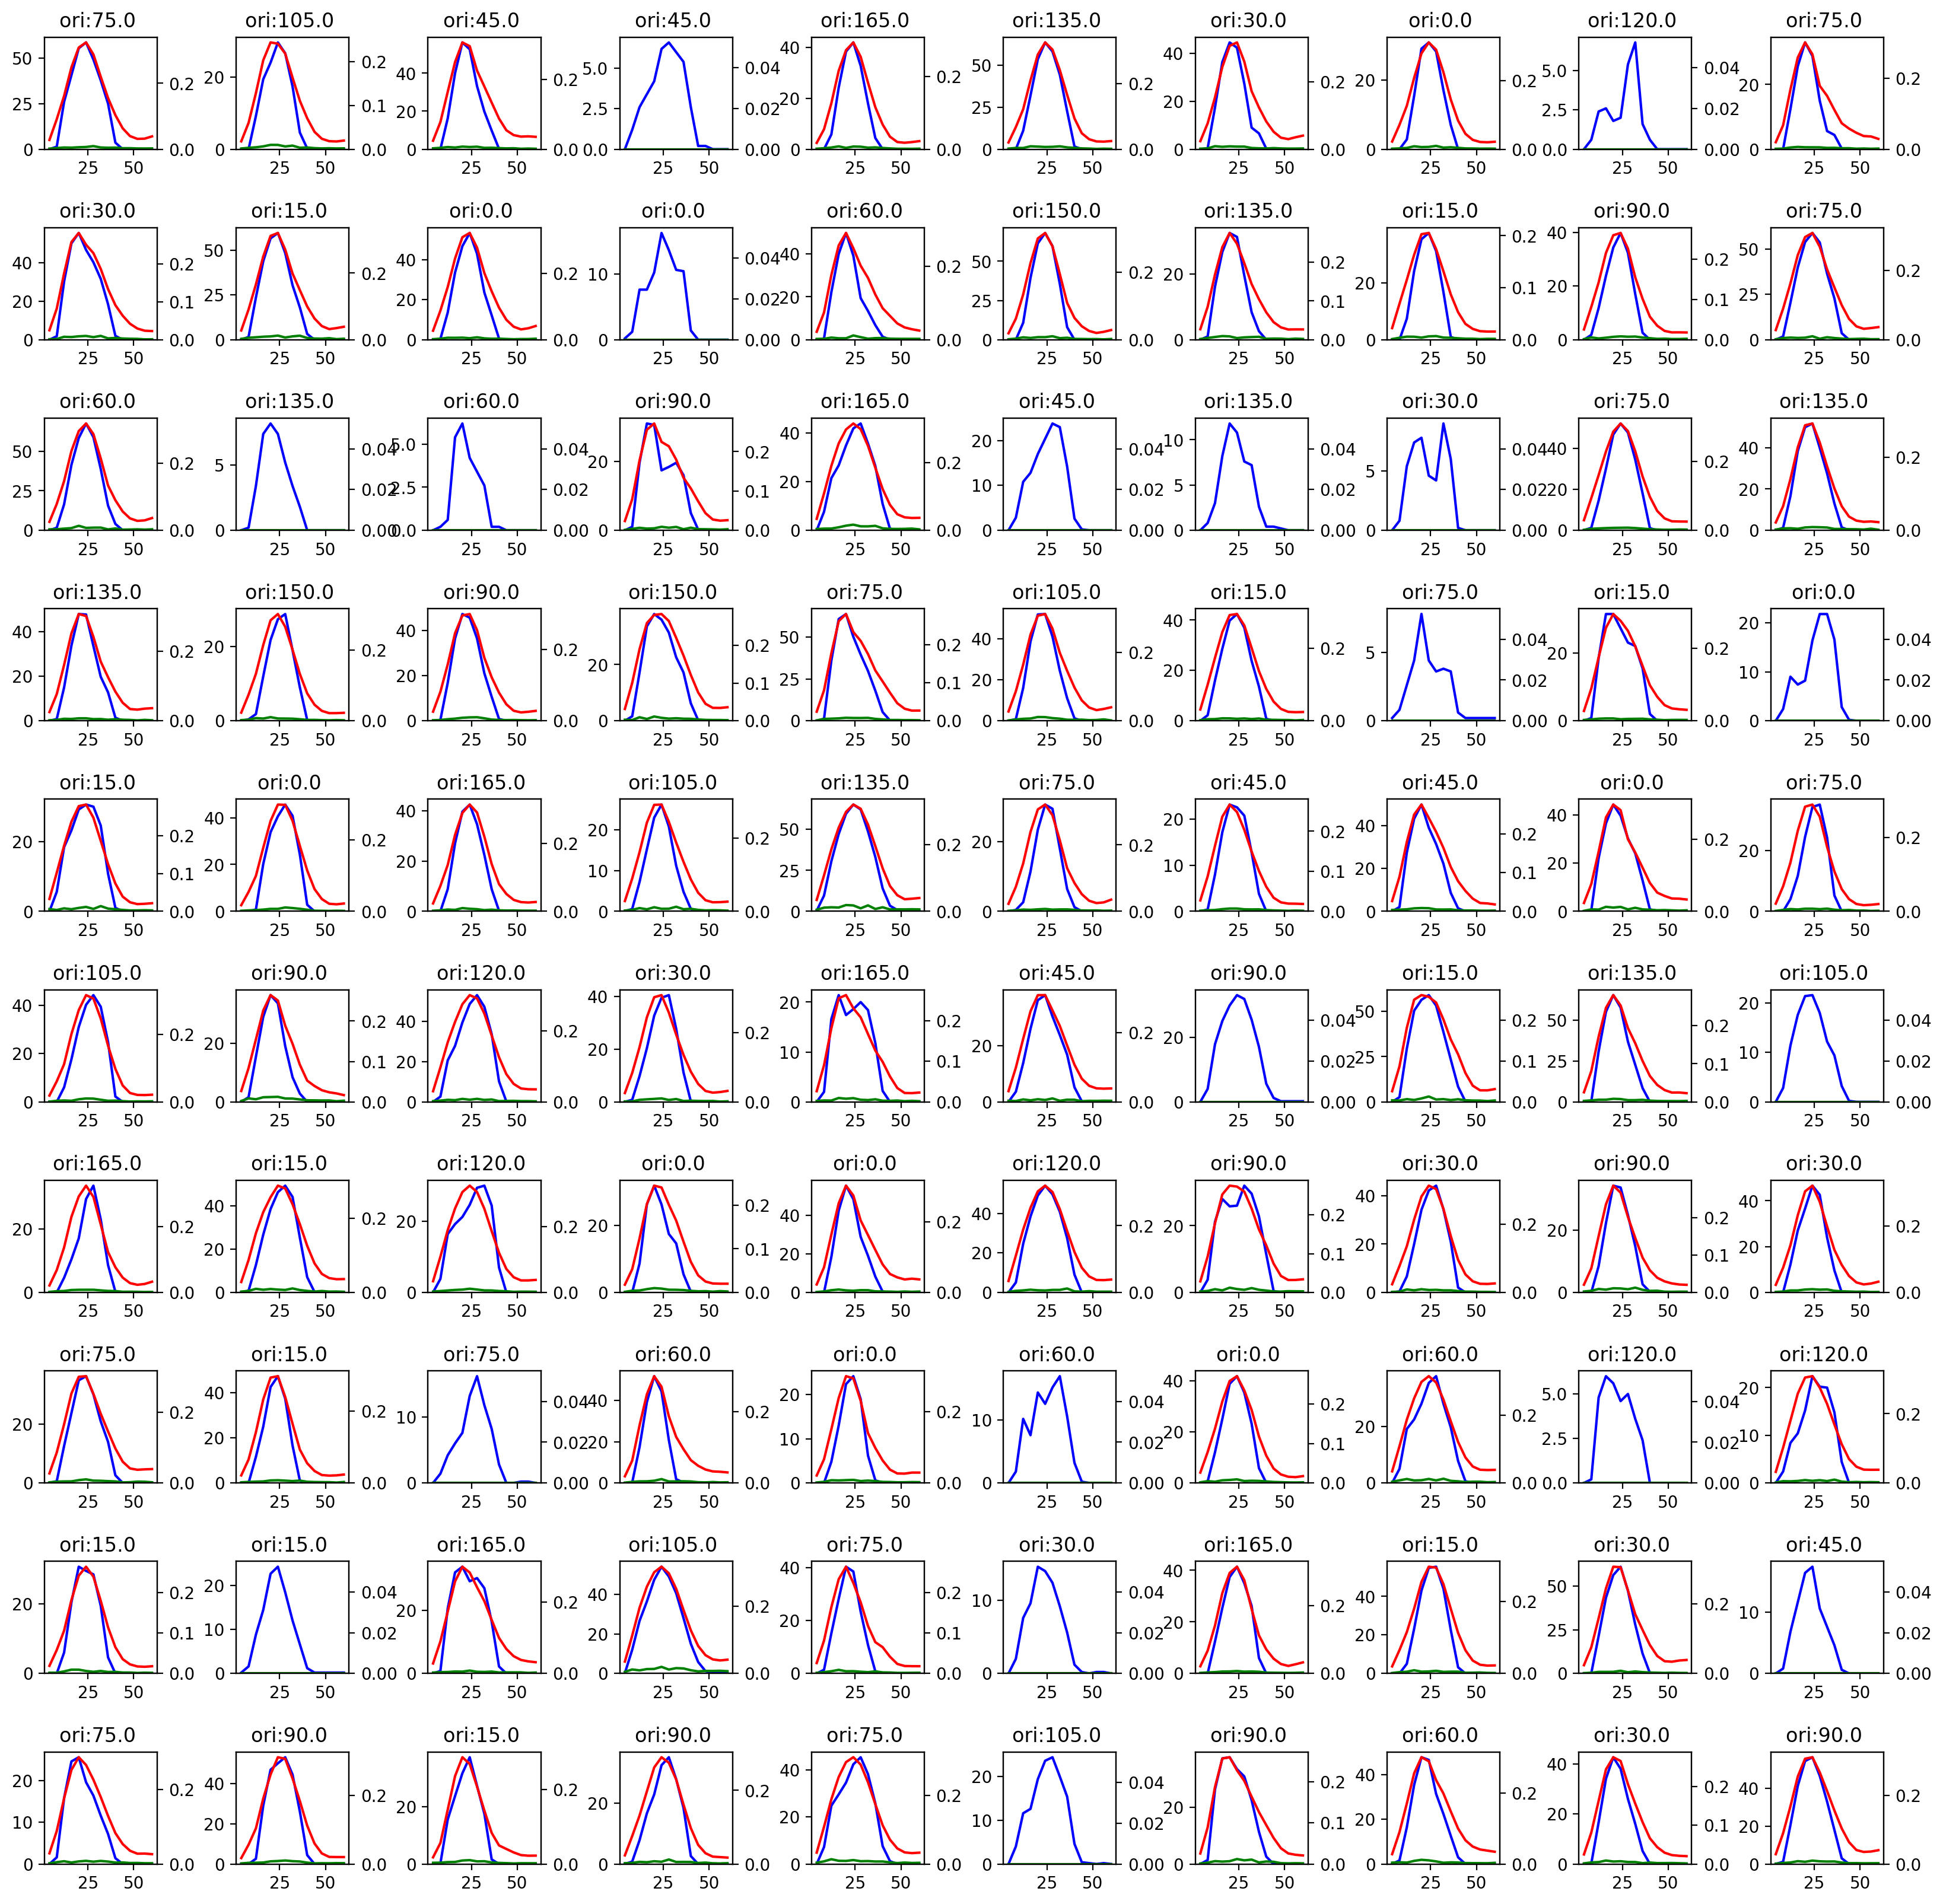

In [109]:
nsf = 15
fig = plt.figure(figsize = (20,20),dpi = 200)
fig.subplots_adjust(hspace = 0.7,wspace = 0.7)
sf = [4+x*4 for x in range(nsf)]
for k in range(100):
    neu_ind = k*5
    tmp_ori = pref_ori[neu_ind]
    tmp_fr = fr[:,neu_ind][cfg[:,1]==tmp_ori]
    tmp_F0 = F0_input[:,neu_ind][cfg[:,1]==tmp_ori]
    tmp_F1 = F1_input[:,neu_ind][cfg[:,1]==tmp_ori]
    
    
    ax = fig.add_subplot(10,10,k+1)
    ax.plot(sf,tmp_fr,'b')
    ax.set_ylim (bottom = 0)
    ax2 = ax.twinx()
    ax2.plot(sf,tmp_F0,'r')
    ax2.plot(sf,tmp_F1,'g')
    ax2.set_ylim (bottom = 0)

    ax.set_title(f'ori:{tmp_ori} ')
    
plt.show()
# fig.savefig('./'+pixel+'_sample_sf_tc.png')   
plt.close()